# Imports

In [120]:
import os
import numpy
import SimpleITK

import scipy.ndimage
import scipy.misc
import scipy.misc as scioM

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from os import listdir
from os.path import isfile, join

In [132]:
from skimage import measure
import skimage as skImg
# for this module the stl is now depricated
# pip install numpy-stl
from stl import mesh

# Functions

## Reading Files

In [4]:
def readMRIFile(inpath):
    # Read an MR file (.dcm,.nii,.mnc) and stores it in an ITK image stack file tensor
    
    reader = SimpleITK.ImageFileReader()
    mriImage = SimpleITK.ReadImage(inpath)
    return mriImage

In [30]:
def convertToNP(itkImage):
    # Converts the a single ITK image into a numpy array
    
    npArray = SimpleITK.GetArrayFromImage(itkImage)
    return npArray    

In [6]:
def applySmoothingMRI(singleMRIImage):
    # Applys smoothing to an ITK image and returns an ITK image
    
    mriImageSmooth = SimpleITK.CurvatureFlow(image1=singleMRIImage,
                                            timeStep=0.125,
                                            numberOfIterations=5)   
    return mriImageSmooth

In [7]:
def readStackOfImage(imageStackDirectory):
    # Get all file names in the firectory 
    onlyFiles = [f for f in listdir(imageStackDirectory) if isfile(join(imageStackDirectory, f))]
    
    # get sizes of each image
    oneFile = imageStackDirectory + onlyFiles[0]
    oneFileImage = scipy.ndimage.imread(oneFile)
    [w,h] = oneFileImage.shape
    
    # Allocate variable for the image stack
    numSlices = len(onlyFiles)
    imageStack = np.zeros((w,h,numSlices))
    
    # Read and store image stack in an array
    for sliceImageFile in onlyFiles:
        imageStack[:,:,sliceInd] = scipy.ndimage.imread(sliceImageFile)
    
    return imageStack

## Get Data Statistics

In [33]:
def getDataStatistics(npArray):
    [numSlices,width,height] = npArray.shape
    print("The data contains {} slices with the image resolution being {} x {}".format(numSlices,width,height))
    
    return [numSlices,width,height]

## Image Processing

In [9]:
def showSegmentation(sliceNum=90):
    # Get slice
    idxSlice = sliceNum
    imgOriginal = image[:,:,idxSlice]

    # Apply smoothing
    imgSmooth = SimpleITK.CurvatureFlow(image1=imgOriginal,
                                        timeStep=0.125,
                                        numberOfIterations=5)
    sitk_show(imgSmooth)

    # Get segmentation
    lstSeeds = [(75,60)]

    imgWhiteMatter = SimpleITK.ConnectedThreshold(image1=imgSmooth, 
                                                  seedList=lstSeeds, 
                                                  lower=0, 
                                                  upper=40,
                                                  replaceValue=labelWhiteMatter)

    # Rescale 'imgSmooth' and cast it to an integer type to match that of 'imgWhiteMatter'
    imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

    # Use 'LabelOverlay' to overlay 'imgSmooth' and 'imgWhiteMatter'
    sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter))

    # show segmentation
    sitk_show(imgWhiteMatter)

In [10]:
def getMask(sliceImage,pxlRanges):
#     sliceImage = np.copy(grayMatterMask[:,:,50])
    xLen,yLen = np.shape(sliceImage)
#     pxlRanges = grayMatterRange
    lower = pxlRanges[0]
    upper = pxlRanges[1]

    for x in xrange(xLen):
        for y in xrange(yLen):        
            if(sliceImage[x,y]>=lower and sliceImage[x,y]<=upper):                        
                sliceImage[x,y] = 1.0
            else:
                sliceImage[x,y] = 0.0
    
    return sliceImage

## Model Generation

In [11]:
def make_mesh(image, threshold=-100, step_size=1):
    # Generates a mesh from a stack of images (image variable)
    
    print "Transposing surface"
    p = image.transpose(2,1,0)
    
    print "Calculating surface"
    try:
        verts, faces = measure.marching_cubes(p, threshold) 
    except:
        verts, faces = measure.marching_cubes_classic(p, threshold)         
    return verts, faces

In [12]:
def make_meshNew(image, threshold=-100, step_size=1):
    # Generates a mesh from a stack of images (image variable)
    
    print "Transposing surface"
#     p = image.transpose(2,1,0)
    p=image
    
    print "Calculating surface"
    try:
        if(threshold==0.0):
            verts, faces = measure.marching_cubes(p) 
        else:            
            verts, faces = measure.marching_cubes(p, threshold) 
    except:
        if(threshold==0.0):
            verts, faces = measure.marching_cubes_classic(p)         
        else:
            verts, faces = measure.marching_cubes_classic(p, threshold)         
    return verts, faces

In [13]:
def generateSTL(fileOut,imageStack,TH=0.0):
    # Note: imageStack is the output of the function readStackOfImage
    
    # Get verticies
    v, f = make_meshNew(imageStack,TH)
    
    # Generate mesh
    imageMesh = mesh.Mesh(np.zeros(f.shape[0], dtype=mesh.Mesh.dtype))
    
    # Connect Vertices
    for i, f in enumerate(f):
        for j in range(3):
            imageMesh.vectors[i][j] = v[f[j],:]
        
    # Create Mesh    
    imageMesh.save(fileOut)    

In [113]:
def generateImageStack(imageStack,outFileDir): 
    # ----------------------------------------------------------------------------
    # imageStack = is a np array with the format [slice,width,height]
    # outFileDir = location where all the images will be saved    
    # ----------------------------------------------------------------------------   
    
    [numSlices,width,height] = imageStack.shape
    
    for sliceInd in xrange(numSlices):
        scioM.imsave(outFileDir + '{}.jpg'.format(sliceInd), imageStack[sliceInd,:,:])
    
    print('Create the image stack in the folder {}'.format(outFileDir))

## Visualization

In [14]:
def sitk_show(img, title=None, margin=0.05, dpi=40 ):
    # Simple visualization tool to view a single slice
    
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [177]:
def resizePlane(mrSlice,w,h):   
    # ----------------------------------------------------------------------------
    # resizedMRImage = image (np array) you want to resize
    # w = value of width
    # h = value of height
    # ----------------------------------------------------------------------------
    resizedMRImage = skImg.transform.resize(mrSlice,(w,h),anti_aliasing =True)
    return resizedMRImage

In [178]:
def getPlanarViewImage(imgStack,indSlice,viewType='axial'):
    # ----------------------------------------------------------------------------
    # imageStack = is a np array with the format [slice,width,height]
    # indSlice = the index of the slice you want to view
    # viewType = string specifying planar views, can be 'axial', 'coronal', 'sagittal'     
    # ----------------------------------------------------------------------------
    [numSlices,width,height] = imgStack.shape    
    
    if(viewType=='axial'):
        mrImage =  imgStack[indSlice,:,:]    
    elif(viewType=='coronal'):
        mrImage =  np.flipud(imgStack[:,indSlice,:])
        mrImage = resizePlane(mrImage,width,height)        
    elif(viewType=='sagittal'):
        mrImage =  np.flipud(np.fliplr(imgStack[:,:,indSlice]))
        mrImage = resizePlane(mrImage,width,height)        
    
    return mrImage    

In [179]:
def display3Slices(imageStack,arrayIndSlice,viewType='axial',cmap="bone"):
    # ----------------------------------------------------------------------------
    # imageStack = is a np array with the format [slice,width,height]
    # arrayIndSlice = is a an array with 3 ind values no greater than max slice,max width or max height
    # viewType = string specifying planar views, can be 'axial', 'coronal', 'sagittal' 
    # cmap = the most commonly used ones are ["gray",'bone','binary','jet', 'gist_ncar','seismic','Set1',]
    # ----------------------------------------------------------------------------
    [numSlices,width,height] = imageStack.shape
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    
    # show first slice
    plt.subplot(1,3,1)    
    plt.set_cmap(cmap)    
    mrImg1 = getPlanarViewImage(imageStack,arrayIndSlice[0],viewType=viewType)
    plt.imshow(mrImg1)
    plt.title('Showing Slice {}'.format(arrayIndSlice[0]))
    
    # show second slice
    plt.subplot(1,3,2)    
    plt.set_cmap(cmap)    
    mrImg1 = getPlanarViewImage(imageStack,arrayIndSlice[1],viewType=viewType)
    plt.imshow(mrImg1)
    plt.title('Showing Slice {}'.format(arrayIndSlice[1]))
    
    # show third slice
    plt.subplot(1,3,3)    
    plt.set_cmap(cmap)    
    mrImg1 = getPlanarViewImage(imageStack,arrayIndSlice[2],viewType=viewType)
    plt.imshow(mrImg1)
    plt.title('Showing Slice {}'.format(arrayIndSlice[2]))
    
    plt.tight_layout()
    plt.show()

![planarViews](https://faculty.washington.edu/chudler/gif/slice.gif)

# Parameters

In [15]:
inpath = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//human//group3//group3//06//06_preop_mri.mnc'

In [102]:
outImageStackPath = 'C://Cerebral//_MarioSandBox//DB//medicalHolography//imgStacks//Human//for3DSlicer//'

# Main

## Reading and clean the stack

In [26]:
mriStack = readMRIFile(inpath)

In [27]:
mriStackSmooth = applySmoothingMRI(mriStack)

In [31]:
mriData = convertToNP(mriStackSmooth)

In [34]:
[numSlices,width,height] = getDataStatistics(mriData)

The data contains 180 slices with the image resolution being 512 x 512


## Visualize some slices

Let's visualize 3 slices to get a rough overview of the data we are dealing with

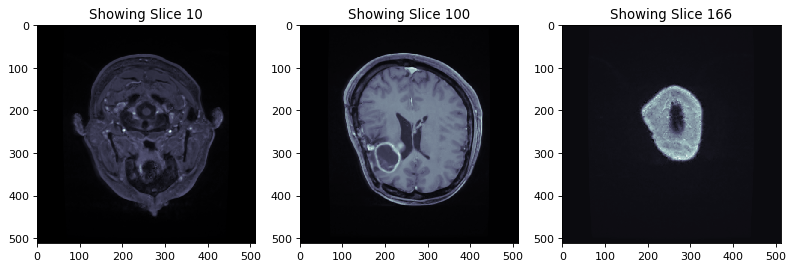

In [173]:
display3Slices(mriData,[10,100,166])

Note: the following images might look distorted and they are, and the reason is that because we have limited number of slices interpolation must be done to resize the image to its original width and height.

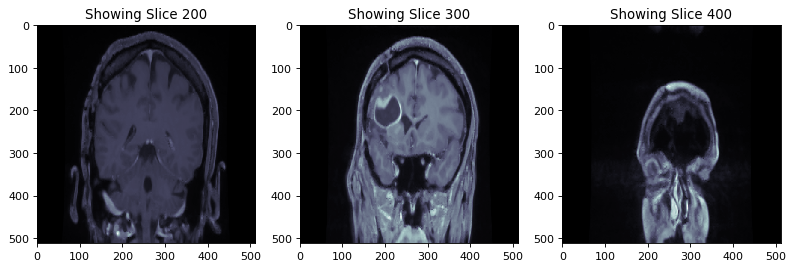

In [175]:
display3Slices(mriData,[200,300,400],viewType='coronal')

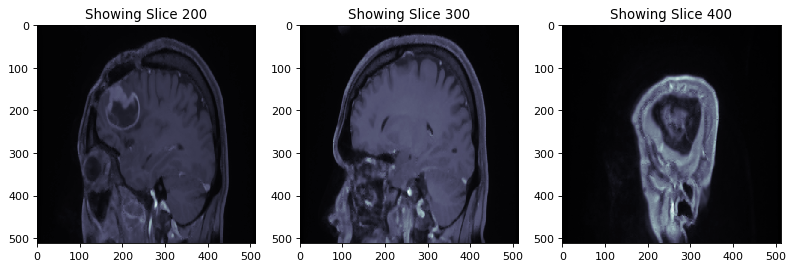

In [176]:
display3Slices(mriData,[200,300,400],viewType='sagittal')

Note the deformation of the coronal and sagittal views because of the limited depth data.  Regardless I think we can use these views to narrow down the slices of interest.

## Generate image stack slices

This will be imported in 3DSlicer to view all the images. Note that this is done to here the most important slices are.

In [114]:
generateImageStack(mriData,outImageStackPath)

C:\Users\HP\Anaconda2\envs\py27\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # Remove the CWD from sys.path while we load stuff.


Create the image stack in the folder C://Cerebral//_MarioSandBox//DB//medicalHolography//imgStacks//Human//for3DSlicer//
